In [3]:
# NOTE: setup code blocks are copied from `process_main_results.ipynb`

In [96]:
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

import textwrap

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to /home/user/kew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/user/kew/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/user/kew/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [47]:
# pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
# pd.set_option('display.width', )
pd.set_option('display.max_colwidth', None)

# set matplotlib style
# plt.style.use('seaborn-whitegrid')
# set font styles and size
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 12

# set seaborn style
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

# set seaborn color palette
sns.set_palette('colorblind')

In [48]:
name_map = {
    'Llama-2-7b-hf': 'Llama-2 (base)',
    # 'llama_2_7b_hf_mono_merged': 'Mono',
    'llama_2_7b_hf_ml1_merged': 'Llama-2 Mono',
    'llama_2_7b_hf_ml2_merged': 'Llama-2 Multi-2',
    'llama_2_7b_hf_ml3_merged': 'Llama-2 Multi-3',
    'llama_2_7b_hf_ml4_merged': 'Llama-2 Multi-4',
    'llama_2_7b_hf_ml5_merged': 'Llama-2 Multi-5',
    'llama_2_7b_hf_ml6_merged': 'Llama-2 Multi-6',
    # 'llama_2_7b_hf_en_merged': 'Multi-6/en',
    'llama_2_7b_hf_es_merged': 'Llama-2 Multi-6/es',
    'llama_2_7b_hf_ru_merged': 'Llama-2 Multi-6/ru',
    'llama_2_7b_hf_de_merged': 'Llama-2 Multi-6/de',
    'llama_2_7b_hf_zh_merged': 'Llama-2 Multi-6/zh',
    'llama_2_7b_hf_fr_merged': 'Llama-2 Multi-6/fr',
    'llama_2_7b_hf_ca_merged': 'Llama-2 Multi-6/ca',
    'llama_2_7b_hf_mt_es_merged': 'Llama-2 MT Multi-6/es', # translated training data
    'llama_2_7b_hf_mt_ru_merged': 'Llama-2 MT Multi-6/ru', # translated training data
    'llama_2_7b_hf_mt_de_merged': 'Llama-2 MT Multi-6/de', # translated training data
    'llama_2_7b_hf_mt_zh_merged': 'Llama-2 MT Multi-6/zh', # translated training data
    'llama_2_7b_hf_mtol_de_merged': 'Llama-2 MTOL Multi-6/de', # translated training data
    'llama_2_7b_hf_mtol_ca_merged': 'Llama-2 MTOL Multi-6/ca', # translated training data
    'llama_2_7b_hf_mt_ml2_n50_merged': 'Llama-2 MT Multi-2 N=50', # translated training data: ablation 4 (fixed ML2, NE=50)
    'llama_2_7b_hf_mt_ml2_n100_merged': 'Llama-2 MT Multi-2 N=100', # translated training data: ablation 4 (fixed ML2, NE=100)
    'llama_2_7b_hf_mt_ml2_merged': 'Llama-2 MT Multi-2', # translated training data / ablation 4 (fixed ML2, NE=200)
    'llama_2_7b_hf_mt_ml2_n300_merged': 'Llama-2 MT Multi-2 N=300', # translated training data: ablation 4 (fixed ML2, NE=300)
    'llama_2_7b_hf_mt_ml2_n400_merged': 'Llama-2 MT Multi-2 N=400', # translated training data: ablation 4 (fixed ML2, NE=400)
    'llama_2_7b_hf_mt_ml2_n1000_merged': 'Llama-2 MT Multi-2 N=1000', # translated training data: ablation 4 (fixed ML2, NE=1000)
    'llama_2_7b_hf_mt_ml3_n5_merged': 'Llama-2 MT Multi-3 N=5', # translated training data: ablation 1 (fixed ML3, NE=10)
    'llama_2_7b_hf_mt_ml3_n10_merged': 'Llama-2 MT Multi-3 N=10', # translated training data: ablation 1 (fixed ML3, NE=20)
    'llama_2_7b_hf_mt_ml3_n25_merged': 'Llama-2 MT Multi-3 N=25', # translated training data: ablation 1 (fixed ML3, NE=50)
    'llama_2_7b_hf_mt_ml3_n50_merged': 'Llama-2 MT Multi-3 N=50', # translated training data: ablation 1 (fixed ML3, NE=100)
    'llama_2_7b_hf_mt_ml3_n100_merged': 'Llama-2 MT Multi-3 N=100', # translated training data: ablation 1 (fixed ML3, NE=200)
    'llama_2_7b_hf_mt_ml3_n500_merged': 'Llama-2 MT Multi-3 N=500', # translated training data: ablation 3 (incremental ML, NE=1000)
    'llama_2_7b_hf_mt_ml3_merged': 'Llama-2 MT Multi-3', # translated training data / ablation 1 (fixed ML3, NE=400) / ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_mt_ml4_merged': 'Llama-2 MT Multi-4', # translated training data
    'llama_2_7b_hf_mt_ml4_n133_merged': 'Llama-2 MT Multi-4 N=133', # translated training data: ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_mt_ml4_n333_merged': 'Llama-2 MT Multi-4 N=333', # translated training data: ablation 3 (incremental ML, NE=1000)
    'llama_2_7b_hf_mt_ml5_merged': 'Llama-2 MT Multi-5', # translated training data
    'llama_2_7b_hf_mt_ml5_n100_merged': 'Llama-2 MT Multi-5 N=100', # translated training data: ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_mt_ml5_n250_merged': 'Llama-2 MT Multi-5 N=250', # translated training data: ablation 3 (incremental ML, NE=1000)
    'llama_2_7b_hf_mt_ml6_merged': 'Llama-2 MT Multi-6', # translated training data
    'llama_2_7b_hf_mt_ml6_n80_merged': 'Llama-2 MT Multi-6 N=80', # translated training data: ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_guanaco_merged': 'Llama-2 Multi-Guanaco',
    'falcon_7b_ml1_merged': 'Falcon Mono',
    'falcon_7b_ml2_merged': 'Falcon Multi-2',
    'falcon_7b_ml3_merged': 'Falcon Multi-3',
    'falcon_7b_ml4_merged': 'Falcon Multi-4',
    'falcon_7b_ml5_merged': 'Falcon Multi-5',
    'falcon_7b_ml6_merged': 'Falcon Multi-6',
    'falcon_7b_es_merged': 'Falcon Multi-6/es',
    'falcon_7b_ru_merged': 'Falcon Multi-6/ru',
    'falcon_7b_de_merged': 'Falcon Multi-6/de',
    'falcon_7b_zh_merged': 'Falcon Multi-6/zh',
    'falcon_7b_fr_merged': 'Falcon Multi-6/fr',
    'falcon_7b_ca_merged': 'Falcon Multi-6/ca',
    'falcon_7b_guanaco_merged': 'Falcon Multi-Guanaco',
    'llama_2_70b_hf_mt_ml1_merged': 'Llama-2 70B Mono', 
    'llama_2_70b_hf_mt_ml2_merged': 'Llama-2 70B MT Multi-2', # translated training data
    'llama_2_70b_hf_mt_ml3_merged': 'Llama-2 70B MT Multi-3', # translated training data
    'llama_2_70b_hf_mt_ml4_merged': 'Llama-2 70B MT Multi-4', # translated training data
    'llama_2_70b_hf_mt_ml5_merged': 'Llama-2 70B MT Multi-5', # translated training data
    'llama_2_70b_hf_mt_ml6_merged': 'Llama-2 70B MT Multi-6', # translated training data
    'llama_2_70b_hf_guanaco_merged': 'Llama-2 70B Multi-Guanaco', # translated training data
    'alpaca_eval_instructions_en': 'en',
    'alpaca_eval_instructions_es': 'es',
    'alpaca_eval_instructions_ru': 'ru',
    'alpaca_eval_instructions_de': 'de',
    'alpaca_eval_instructions_zh': 'zh',
    'alpaca_eval_instructions_fr': 'fr',
    'alpaca_eval_instructions_ca': 'ca',
    'alpaca_eval_instructions_sv': 'sv',
    'alpaca_eval_instructions_bg': 'bg',
    'alpaca_eval_instructions_no': 'no',
    'alpaca_eval_instructions_da': 'da',
    'alpaca_eval_instructions_is': 'is',
    'alpaca_eval_instructions_hi': 'hi',
    'alpaca_eval_instructions_el': 'el',
    'flores_devtest_en_es': 'es',
    'flores_devtest_en_ru': 'ru',
    'flores_devtest_en_de': 'de',
    'flores_devtest_en_zh': 'zh',
    'flores_devtest_en_fr': 'fr',
    'flores_devtest_en_ca': 'ca',
    'flores_devtest_en_sv': 'sv',
    'flores_devtest_en_bg': 'bg',
    'flores_devtest_en_no': 'no',
    'flores_devtest_en_da': 'da',
    'flores_devtest_en_is': 'is',
    'flores_devtest_en_hi': 'hi',
    'flores_devtest_en_el': 'el',
    # XCSQA
    'xcsqa_dev_en_en': 'en:en',
    'xcsqa_dev_en_es': 'en:es',
    'xcsqa_dev_en_ru': 'en:ru',
    'xcsqa_dev_en_de': 'en:de',
    'xcsqa_dev_en_zh': 'en:zh',
    'xcsqa_dev_en_fr': 'en:fr',
    'xcsqa_dev_en_hi': 'en:hi',
    'xcsqa_dev_es_es': 'es:es',
    'xcsqa_dev_ru_ru': 'ru:ru',
    'xcsqa_dev_de_de': 'de:de',
    'xcsqa_dev_zh_zh': 'zh:zh',
    'xcsqa_dev_fr_fr': 'fr:fr',
    'xcsqa_dev_hi_hi': 'hi:hi',
    # XQuAD
    'xquad_dev_en_en': 'en:en',
    'xquad_dev_en_es': 'en:es',
    'xquad_dev_es_es': 'es:es',
    'xquad_dev_en_ru': 'en:ru',
    'xquad_dev_ru_ru': 'ru:ru',
    'xquad_dev_en_de': 'en:de',
    'xquad_dev_de_de': 'de:de',
    'xquad_dev_en_zh': 'en:zh',
    'xquad_dev_zh_zh': 'zh:zh',
    'xquad_dev_en_hi': 'en:hi',
    'xquad_dev_hi_hi': 'hi:hi',
    'xquad_dev_en_el': 'en:el',
    'xquad_dev_el_el': 'el:el',
    'xquad_dev_en_ar': 'en:ar',
    'xquad_dev_ar_ar': 'ar:ar', 
    'xquad_dev_en_tr': 'en:tr',
    'xquad_dev_tr_tr': 'tr:tr',
    'xquad_dev_en_vi': 'en:vi',
    'xquad_dev_vi_vi': 'vi:vi',
    'xquad_dev_en_th': 'en:th',
    'xquad_dev_th_th': 'th:th',
}

training_langs = {
    'Mono': ['en'],
    'Multi-2': ['en', 'es'],
    'Multi-3': ['en', 'es', 'ru'],
    # 'N=5': ['en', 'es', 'ru'],
    # 'N=10': ['en', 'es', 'ru'],
    # 'N=25': ['en', 'es', 'ru'],
    # 'N=50': ['en', 'es', 'ru'],
    # 'N=100': ['en', 'es', 'ru'],
    # 'N=1000': ['en', 'es'], # 1000/1 + en
    # 'N=500': ['en', 'es', 'ru'], # 1000/2 + en
    # 'N=333': ['en', 'es', 'ru', 'de'], # 1000/3 + en
    # 'N=250': ['en', 'es', 'ru', 'de', 'zh'], # 1000/4 + en
    'Multi-4': ['en', 'es', 'ru', 'de'],
    'Multi-5': ['en', 'es', 'ru', 'de', 'zh'],
    'Multi-6': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'Multi-6/de': ['en', 'es', 'ru', 'zh', 'fr', 'ca'],
    'Multi-6/fr': ['en', 'es', 'ru', 'de', 'zh', 'ca'],
    'Multi-6/zh': ['en', 'es', 'ru', 'de', 'fr', 'ca'],
    'Multi-6/es': ['en', 'ru', 'de', 'zh', 'fr', 'ca'],
    'Multi-6/ru': ['en', 'es', 'de', 'zh', 'fr', 'ca'],
    'Multi-6/ca': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'Multi-Guanaco': ['es', 'en', 'ru', 'de', 'zh', 'fr', 'ca', 'th', 'pt', 'it', 'uk', 'eu', 'jp', 'pl', 'zh', 'vi', 'hu', 'gn', 'da', 'tr', 'nl', 'gl', 'mt', 'ar', 'ms', 'sc', 'nn', 'ko', 'ht', 'ar', 'id', 'ar', 'wo', 'uz', 'lv', 'jv', 'fi', 'tk', 'tg', 'sv', 'so', 'sl', 'sk', 'no', 'kk', 'ga', 'cz'],
}

def load_json(file):
    with open(file, "r", encoding='utf8') as f:
        return json.load(f)

def parse_filename(file):
    """
    resources/outputs/llama_2_7b_hf_en_merged/alpaca_eval_instructions_ru-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.eval
    """
    # get test set and context, allowing for no context
    model_name = Path(file).parent.name
    parts = Path(file).stem.split('-')

    test_set = parts[0]
    context = parts[1]
    prompt = parts[2]
    seed = int(parts[3][1:])
    top_k = int(parts[4][1:])
    top_p = float(parts[5][1:])
    temp = float(parts[6][1:])
    bs = int(parts[7][1:])

    has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = None, None, None, None, None, None
    if len(parts) > 8:

        # with_en-l300-ds42-as42-source_en-system_en
        has_translation = parts[8] == 'with_en'
        n_eval_items = int(parts[-5][1:])
        data_seed = int(parts[-4][2:])
        api_seed = int(parts[-3][2:])
        eval_src = parts[-2]
        eval_tgt = parts[-1]

    return model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt

# sort models given the order in name_map
ordered_model_names = [v for k, v in name_map.items() if k.lower().startswith('llama') or k.lower().startswith('falcon')]
print(ordered_model_names)
ordered_alpaca_test_sets = [v for k, v in name_map.items() if k.startswith('alpaca')]
print(ordered_alpaca_test_sets)
ordered_flores_test_sets = [v for k, v in name_map.items() if k.startswith('flores')]
print(ordered_flores_test_sets)
ordered_xcsr_test_sets = [v for k, v in name_map.items() if k.startswith('xcsqa')]
print(ordered_xcsr_test_sets)
ordered_xquad_test_sets = [v for k, v in name_map.items() if k.startswith('xquad')]
print(ordered_xquad_test_sets)

def apply_sort(df, ordered_test_sets, ordered_model_names=ordered_model_names):

    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df['test_set'] = pd.Categorical(df['test_set'], ordered_test_sets)

    if 'seed' in df.columns:
        df = df.sort_values(by=['model_name', 'test_set', 'seed'])
    else:
        df = df.sort_values(by=['model_name', 'test_set'])

    # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    df['test_set'] = df['test_set'].astype(str)
        
    df = df.reset_index(drop=True)

    df.info()
    
    return df

['Llama-2 (base)', 'Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-6/es', 'Llama-2 Multi-6/ru', 'Llama-2 Multi-6/de', 'Llama-2 Multi-6/zh', 'Llama-2 Multi-6/fr', 'Llama-2 Multi-6/ca', 'Llama-2 MT Multi-6/es', 'Llama-2 MT Multi-6/ru', 'Llama-2 MT Multi-6/de', 'Llama-2 MT Multi-6/zh', 'Llama-2 MTOL Multi-6/de', 'Llama-2 MTOL Multi-6/ca', 'Llama-2 MT Multi-2 N=50', 'Llama-2 MT Multi-2 N=100', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-2 N=300', 'Llama-2 MT Multi-2 N=400', 'Llama-2 MT Multi-2 N=1000', 'Llama-2 MT Multi-3 N=5', 'Llama-2 MT Multi-3 N=10', 'Llama-2 MT Multi-3 N=25', 'Llama-2 MT Multi-3 N=50', 'Llama-2 MT Multi-3 N=100', 'Llama-2 MT Multi-3 N=500', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-4 N=133', 'Llama-2 MT Multi-4 N=333', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-5 N=100', 'Llama-2 MT Multi-5 N=250', 'Llama-2 MT Multi-6', 'Llama-2 MT Multi-6 N=80', 'Llama-2 Multi-Guanaco', 'Falcon

In [49]:
def get_llm_judge_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for llm_eval_file in sorted(Path(results_dir).glob('*/*/*.jsonl')):
        # print(llm_eval_file)
        df = pd.read_json(llm_eval_file, lines=True)

        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(llm_eval_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        df['n_eval_items'] = n_eval_items
        df['data_seed'] = data_seed
        df['api_seed'] = api_seed
        df['eval_src'] = eval_src
        df['eval_tgt'] = eval_tgt
        df['eval_model'] = llm_eval_file.parent.parent.name

        dfs.append(df)
            
    print(f'Gathered {len(dfs)} dataframes.')
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('eval_src')))
    cols.insert(4, cols.pop(cols.index('eval_tgt')))
    print(cols)
    df = df.reindex(columns=cols)

    return df

df = get_llm_judge_results('data/llm_judge/likert')
print(len(df))

# inspect rows with NaN values in eval_score
# df[df['eval_score'].isna()]
# df[df['eval_score'] == 0]

# drop rows containing isna values in eval_score
df = df.dropna(subset=['eval_score'])
print(len(df))

# drop rows where eval_score is not between 1 and 6
df = df[(df['eval_score'] >= 1) & (df['eval_score'] <= 6)]
print(len(df))

# if 'system_lang' does not match 'source_lang', then set 'eval_score' to 1
df.loc[df['system_lang'] != df['source_lang'], 'eval_score'] = 1

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

# discard column with name "eval_Should I leave him. How do I like it?" - occurs once due to parsing errors from jsonl object returned from llm
# data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_el-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source_en-system_en.jsonl
df = df.drop(columns=['eval_Should I leave him. How do I like it?'])

df = apply_sort(df, ordered_test_sets=ordered_alpaca_test_sets)

# inspect total tokens from eval_meta
eval_costs = []
for i, row in df.iterrows():
    # eval_tokens.append(row['eval_meta']['prompt_tokens'] + row['eval_meta']['completion_tokens'])
    cost = row['eval_meta']['cost']
    if isinstance(row['translation_meta'], dict):
        cost += row['translation_meta']['cost']
    eval_costs.append(cost)

print(len(df))
print(len(eval_costs))
print(np.mean(eval_costs))
print(max(eval_costs))
print(min(eval_costs))
print(sum(eval_costs))

# check that for each model, the same ids are evaluated
all_ids = set()
for model_name in df['model_name'].unique():
    ids = df[df['model_name'] == model_name]['id'].unique()
    all_ids.update(ids)
print(len(all_ids))

print(df.columns)
df.info()

Gathered 1214 dataframes.
['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt', 'prompt', 'system', 'finish_reason', 'source', 'secs', 'id', 'eval_reasoning', 'eval_score', 'eval_meta', 'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed', 'api_seed', 'eval_model', 'eval_Pizzeria,', 'source_en', 'system_en', 'translation_meta', 'eval_Should I leave him. How do I like it?']
364200
364089
363781
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363781 entries, 0 to 363780
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   model_name        363781 non-null  object 
 1   test_set          363781 non-null  object 
 2   seed              363781 non-null  int64  
 3   eval_src          363781 non-null  object 
 4   eval_tgt          363781 non-null  object 
 5   prompt            363781 non-null  object 
 6   system            363781 non-null  object 
 7   finish_reason     363781 non-null 

In [50]:
df['test_set'].value_counts()

de    38068
zh    38039
ru    37139
fr    29071
es    28774
no    24287
bg    24283
is    24276
sv    24274
el    24268
hi    24263
en    23670
ca    23369
Name: test_set, dtype: int64

In [156]:
# process eval_reasoning

lemmatizer = WordNetLemmatizer()

swords = set(stopwords.words('english'))
# remove negation words from stopwords
# swords = swords.difference({'no', 'not', 'nor', 'neither', 'never', 'none', 'nobody', 'nowhere', 'nothing', 'noone', "don't", "doesn't", "does", "could", "should", "would", "might"})
swords = set([
    'however',
    'therefore',
    'moreover',
    'nevertheless',
    'nonetheless',
    'though',
    'although',
    'overall',
    'furthermore',
    'consequently',
    'instead',
    'meanwhile',
    'likewise',
    'otherwise',
    'regardless',
    'subsequently',
    'thus',
    'accordingly',
    'besides',
    'hence',
    'indeed',
    'then',
    'yet',
    'still',
    'also',
    'so',
    'submission',
    'response',
])

def process_reasoning(df):
    
    print(len(df))
    
    # split reasoning into sentences
    df['reasoning_sentences'] = df['eval_reasoning'].progress_apply(sent_tokenize)
    
    # tokenize sentences and remove stopwords
    df['reasoning_tokens'] = df['reasoning_sentences'].progress_apply(lambda x: [w for s in x for w in word_tokenize(s.lower()) if w not in swords])

    # get desctiptive words used in reasoning by part of speech tagging    
    df['reasoning_tagged'] = df['eval_reasoning'].progress_apply(lambda x: pos_tag(word_tokenize(x), tagset='universal'))

    # filter out non-descriptive words
    descriptive_tags = ['ADJ', 'ADV', 'NOUN', 'VERB']
    df['descriptive_words'] = df['reasoning_tagged'].progress_apply(lambda x: [w for w, t in x if t in descriptive_tags])

    return df

def process_text(text):

    # split reasoning into sentences
    reasoning_sentences = sent_tokenize(text)

    # summarized reasoning
    sum_sents = []
    for sent in reasoning_sentences:
        # tokenize amd tag words
        tagged = pos_tag(word_tokenize(sent), tagset='universal')
        
        # lemmitize words
        
        lemmatized = [(lemmatizer.lemmatize(w), t) for w, t in tagged]

        # filter out non-descriptive words and stopwords
        descriptive_words = [w.lower() for w, t in lemmatized if t in ['ADJ', 'ADV', 'NOUN', 'VERB'] and w.lower() not in swords]

        # join descriptive words
        sum_sents.append(' '.join(descriptive_words))
    
    return sum_sents

# get common words from summarized reasoning
def inspect_common_words(df):
    common_words = Counter()
    for i, row in df.iterrows():
        for sent in row['summarized_reasoning']:
            common_words.update(sent.split())
    return common_words.most_common(50)

def plot(df, save_path=None):

    # infer language from test_set
    langs = df['test_set'].unique()
    if len(langs) == 1:
        lang = langs[0]
    else:
        raise ValueError(f'Multiple languages found: {langs}')

    fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)

    # get 6 divergent colours from seaborn RdYlGn
    colors = sns.color_palette('RdYlGn', 6)[::-1]

    # get most common summarize_reasoning sents by eval_score
    for axes_i, score in enumerate(sorted(df['eval_score'].unique())[::-1]):
        c = Counter()
        sub_df = df[df['eval_score'] == score]
        for _, row in sub_df.iterrows():
            c.update(row['summarized_reasoning'])
        
        # filter empty strings
        c = Counter({k: v for k, v in c.items() if k})

        sents = [sent for sent, count in c.most_common(10)]
        counts = [count for sent, count in c.most_common(10)]
        
        # plot most common summarize_reasoning sents by eval_score
        ax = axes.flatten()[axes_i]
        # make hozizontal bar plot with sentence text on y-axis and count on x-axis
        sns.barplot(x=counts, y=sents, ax=ax, alpha=0.8, color=colors[axes_i])

        # infer x offset from max count: 0.1 * max count
        x_offset = 0.02 * max(counts)

        # Add y-axis labels (short texts) above each bar
        for i, (sent, count) in enumerate(zip(sents, counts)):
            # infer text width from ax x-axis span
            # width = ax.get_xlim()[1] - ax.get_xlim()[0]
            sent = '\n'.join(textwrap.wrap(sent, width=65))
            ax.text(x_offset, i, f'{sent}', ha='left', va='center', color='black', fontsize=10)
            ax.set_yticklabels([])

        # put y-axis labels inside plot area
        ax.yaxis.tick_left()
        ax.set_title(f'Eval Score: {score}')
        if axes_i == 0 or axes_i == 3:
            ax.set_ylabel('Reasoning')

    # set fig level x-axis label
    # fig.text(0.5, 0.04, 'Count', ha='center', va='center')

    plt.tight_layout()
        
    if save_path:
        fig.savefig(Path(save_path) / f'llm_judge_reasoning_{lang}.png', dpi=300, bbox_inches='tight')
        fig.savefig(Path(save_path) / f'llm_judge_reasoning_{lang}.pdf', dpi=300, bbox_inches='tight')

    return

def analyse_results_by_lang(df, lang, save_path='./data/plots'):
    # filter by lang
    sdf = df[df['test_set'] == lang]
    print(f'Total results in {lang}: {len(sdf)}')
    
    # only consider rows where eval_src is source and eval_tgt is system (i.e. direct non-english evaluation setting)
    sdf = sdf[(sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system')]
    print(f'Filtered results in {lang}: {len(sdf)}')

    sdf['summarized_reasoning'] = sdf['eval_reasoning'].progress_apply(process_text)
    plot(sdf, save_path=save_path)

    return sdf

Total results in zh: 38039
Filtered results in zh: 37139


100%|██████████| 37139/37139 [01:58<00:00, 312.86it/s]


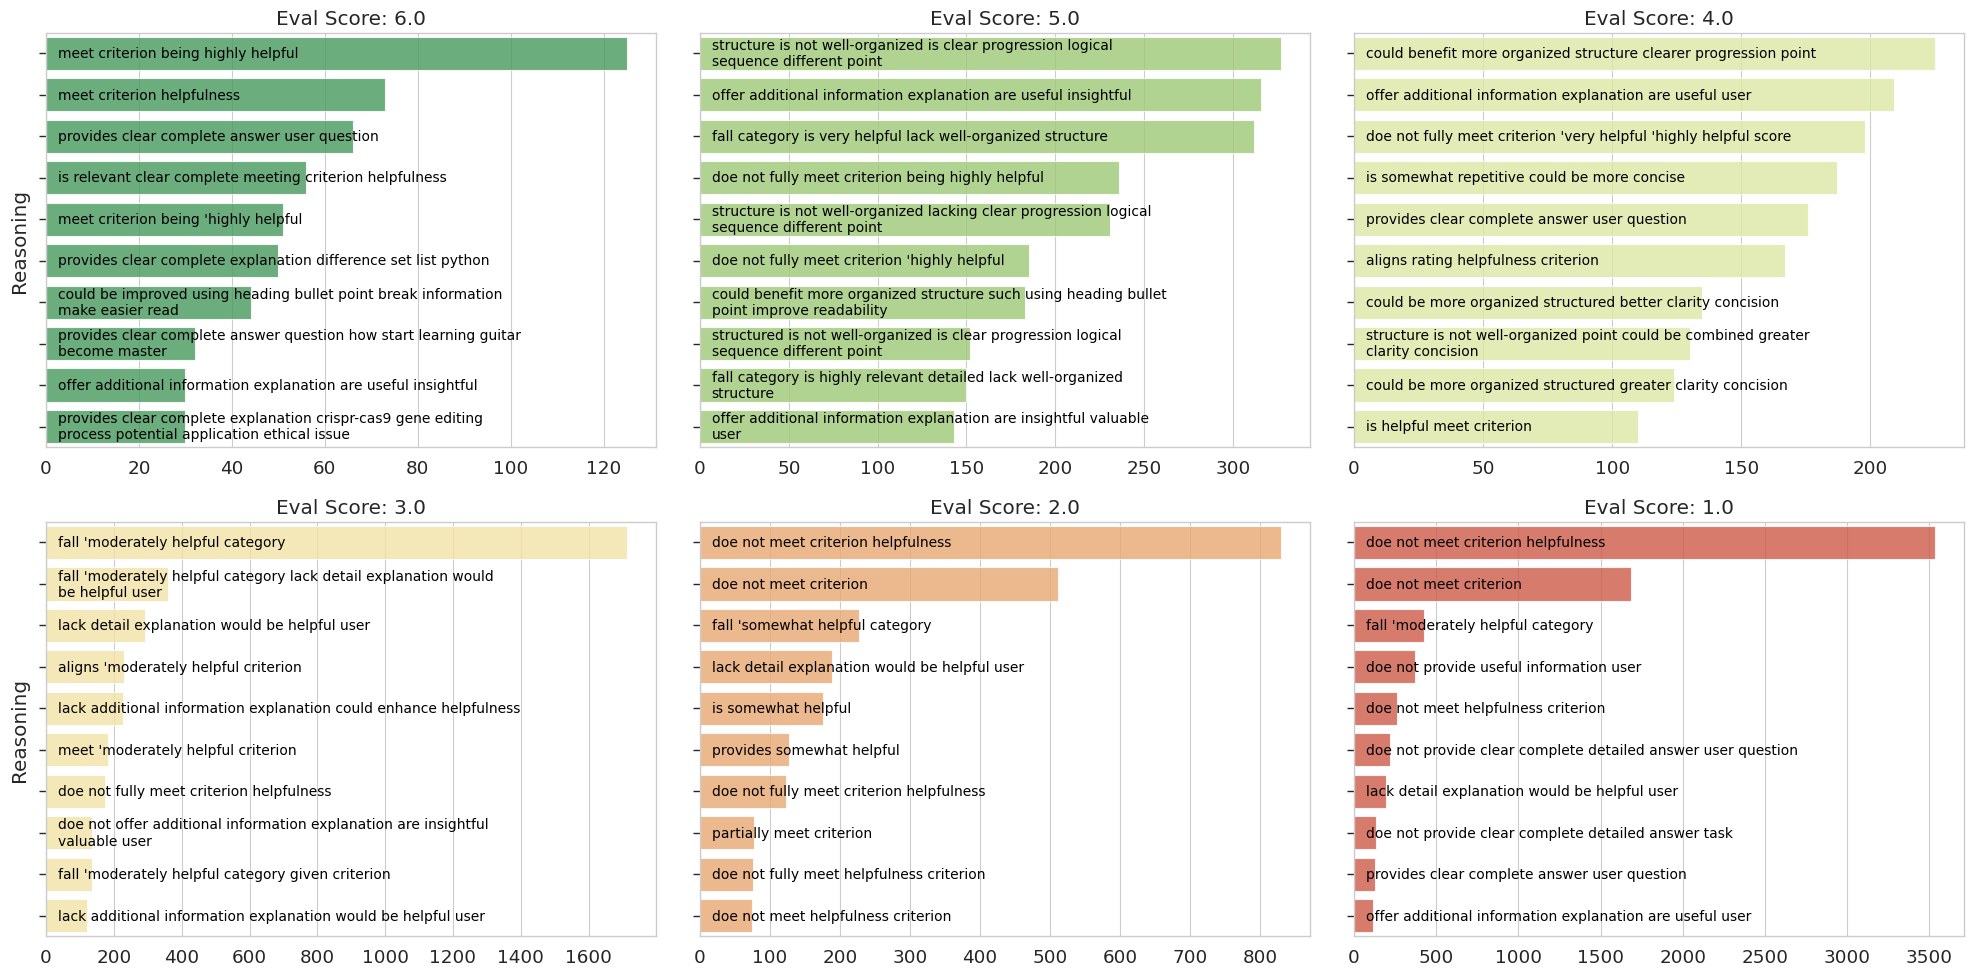

In [157]:
zhdf = analyse_results_by_lang(df, 'zh')

Total results in en: 23670
Filtered results in en: 23670


  0%|          | 96/23670 [00:00<01:16, 309.59it/s]

100%|██████████| 23670/23670 [01:17<00:00, 305.92it/s]


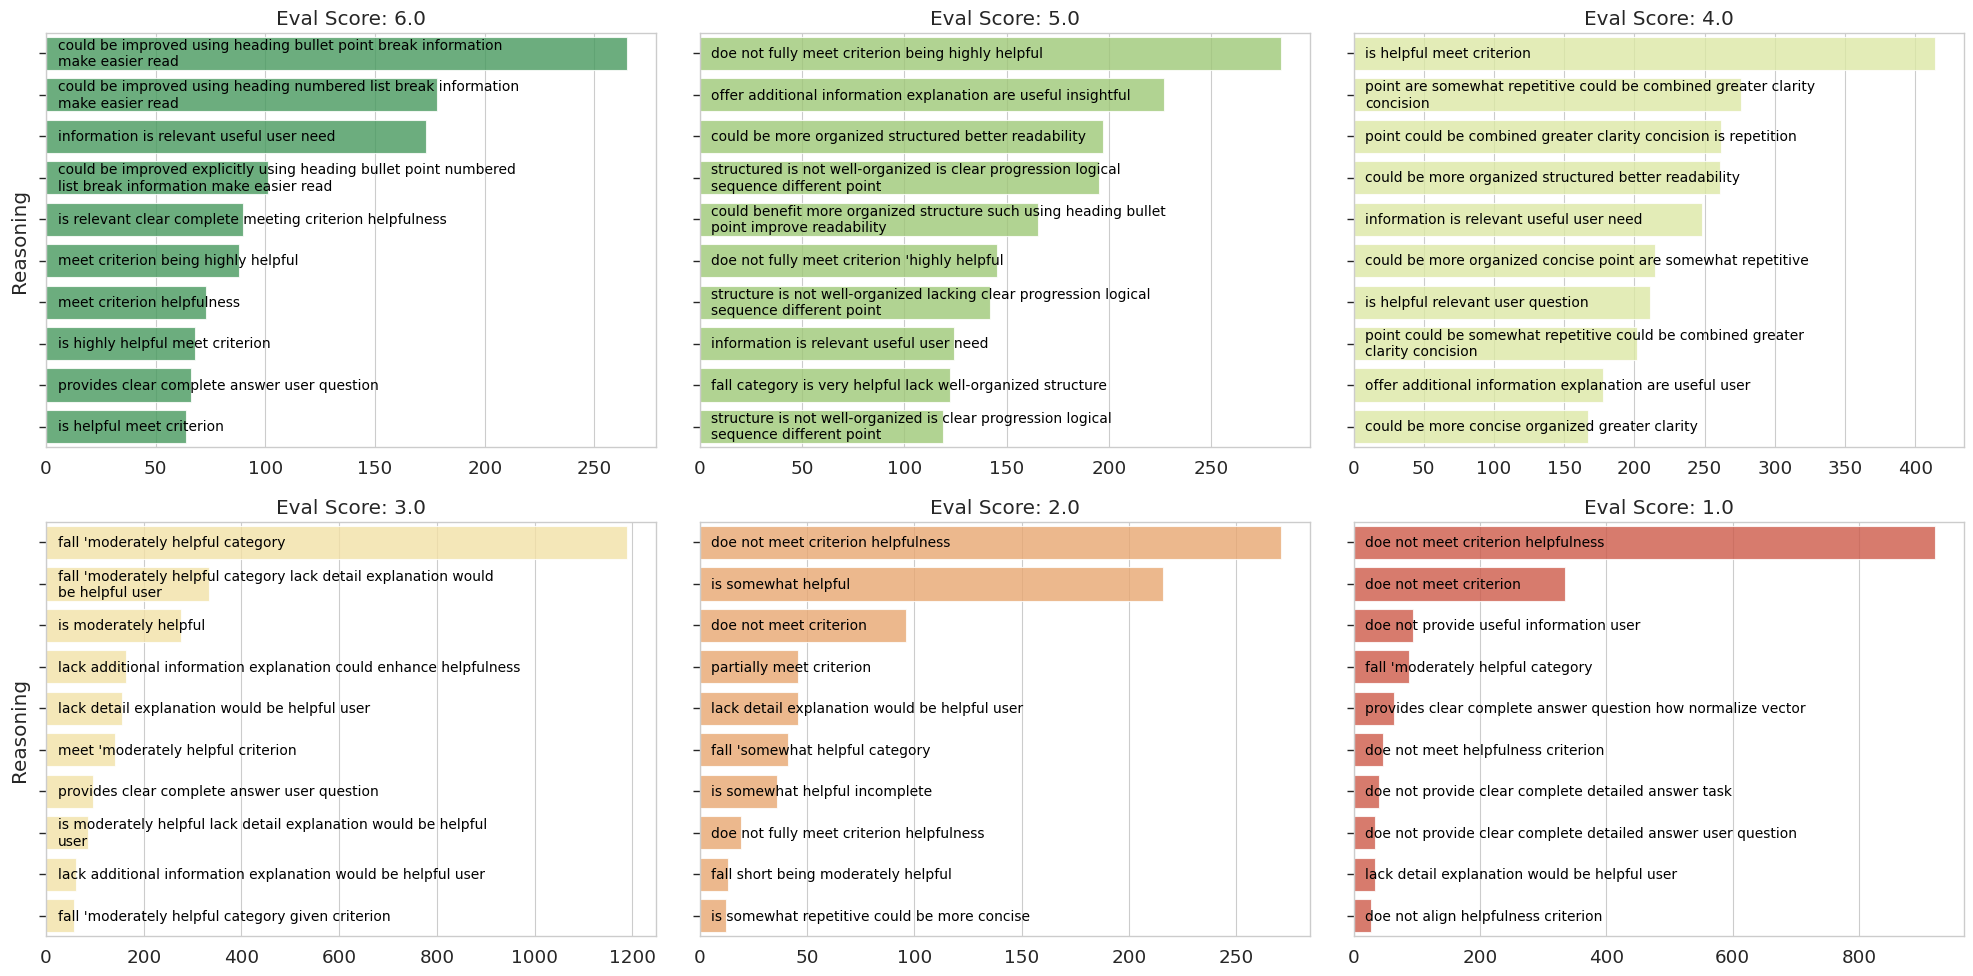

In [158]:
endf = analyse_results_by_lang(df, 'en')

Total results in de: 38068
Filtered results in de: 37169


  0%|          | 67/37169 [00:00<01:54, 323.67it/s]

100%|██████████| 37169/37169 [01:58<00:00, 313.16it/s]


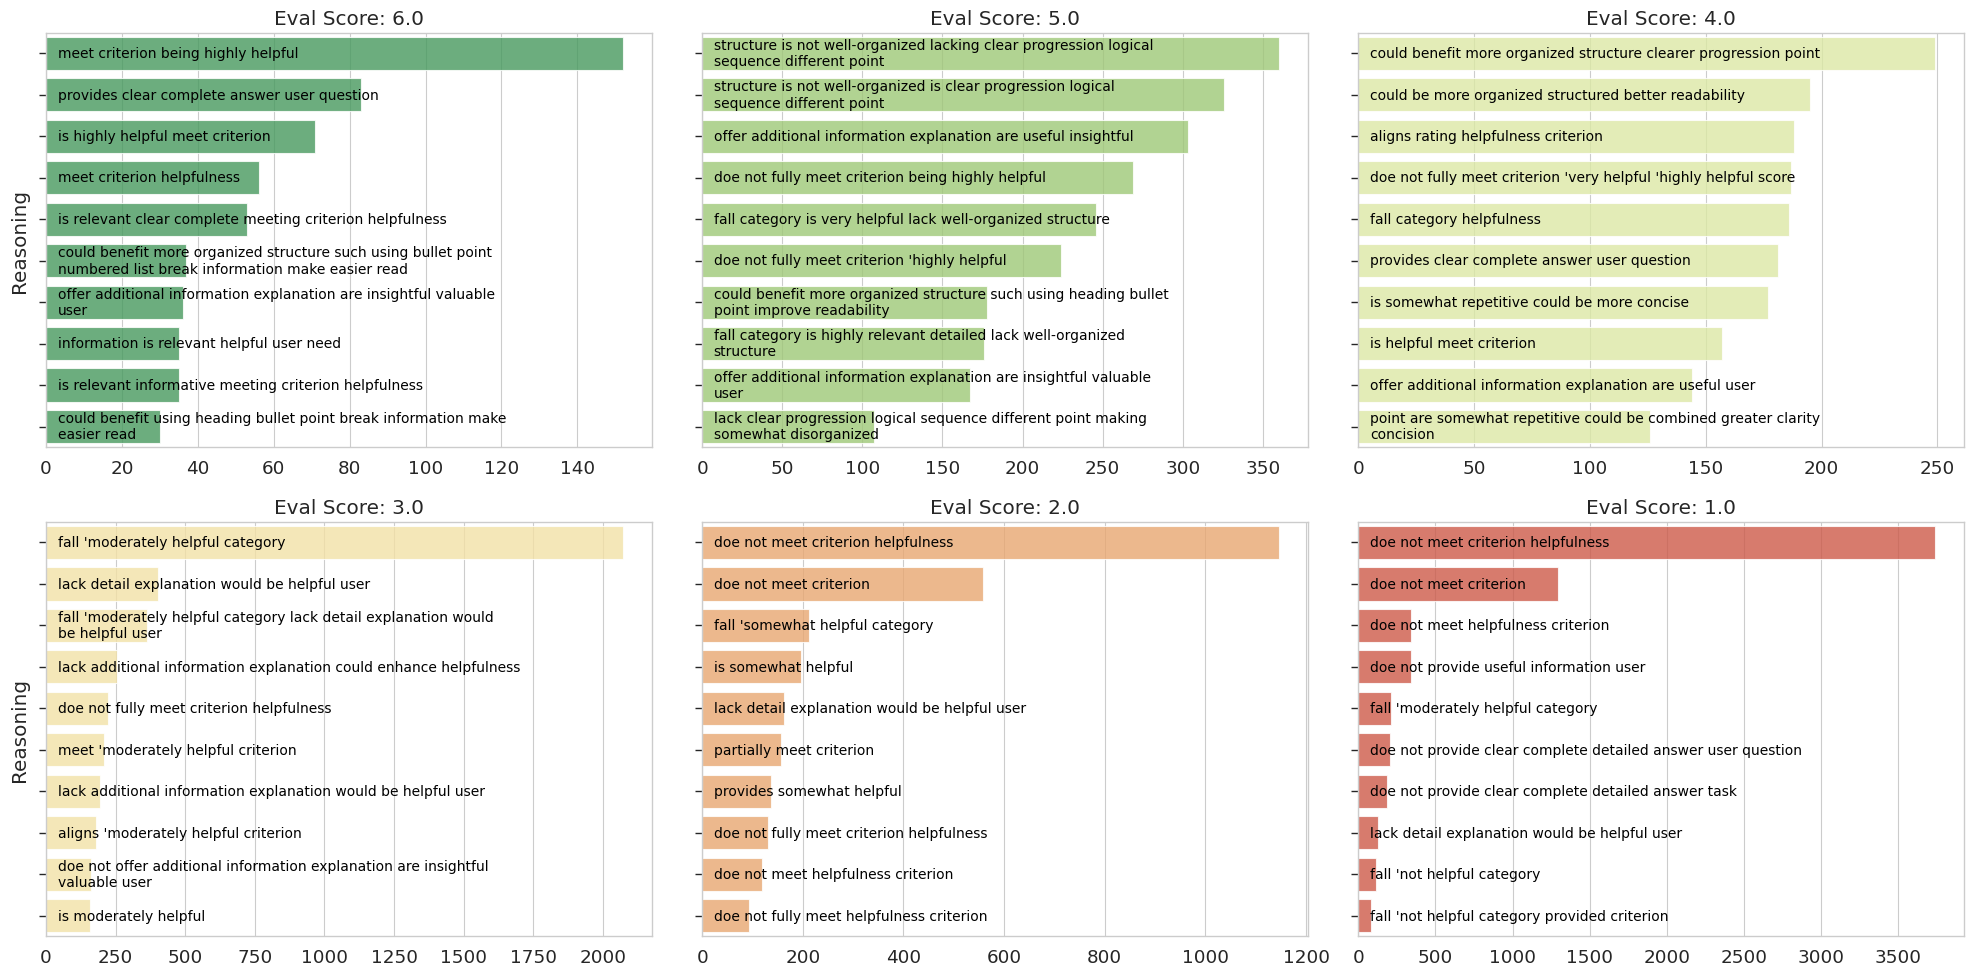

In [159]:
dedf = analyse_results_by_lang(df, 'de')


Total results in ru: 37139
Filtered results in ru: 36241


  0%|          | 133/36241 [00:00<01:54, 315.27it/s]

100%|██████████| 36241/36241 [01:51<00:00, 325.91it/s]


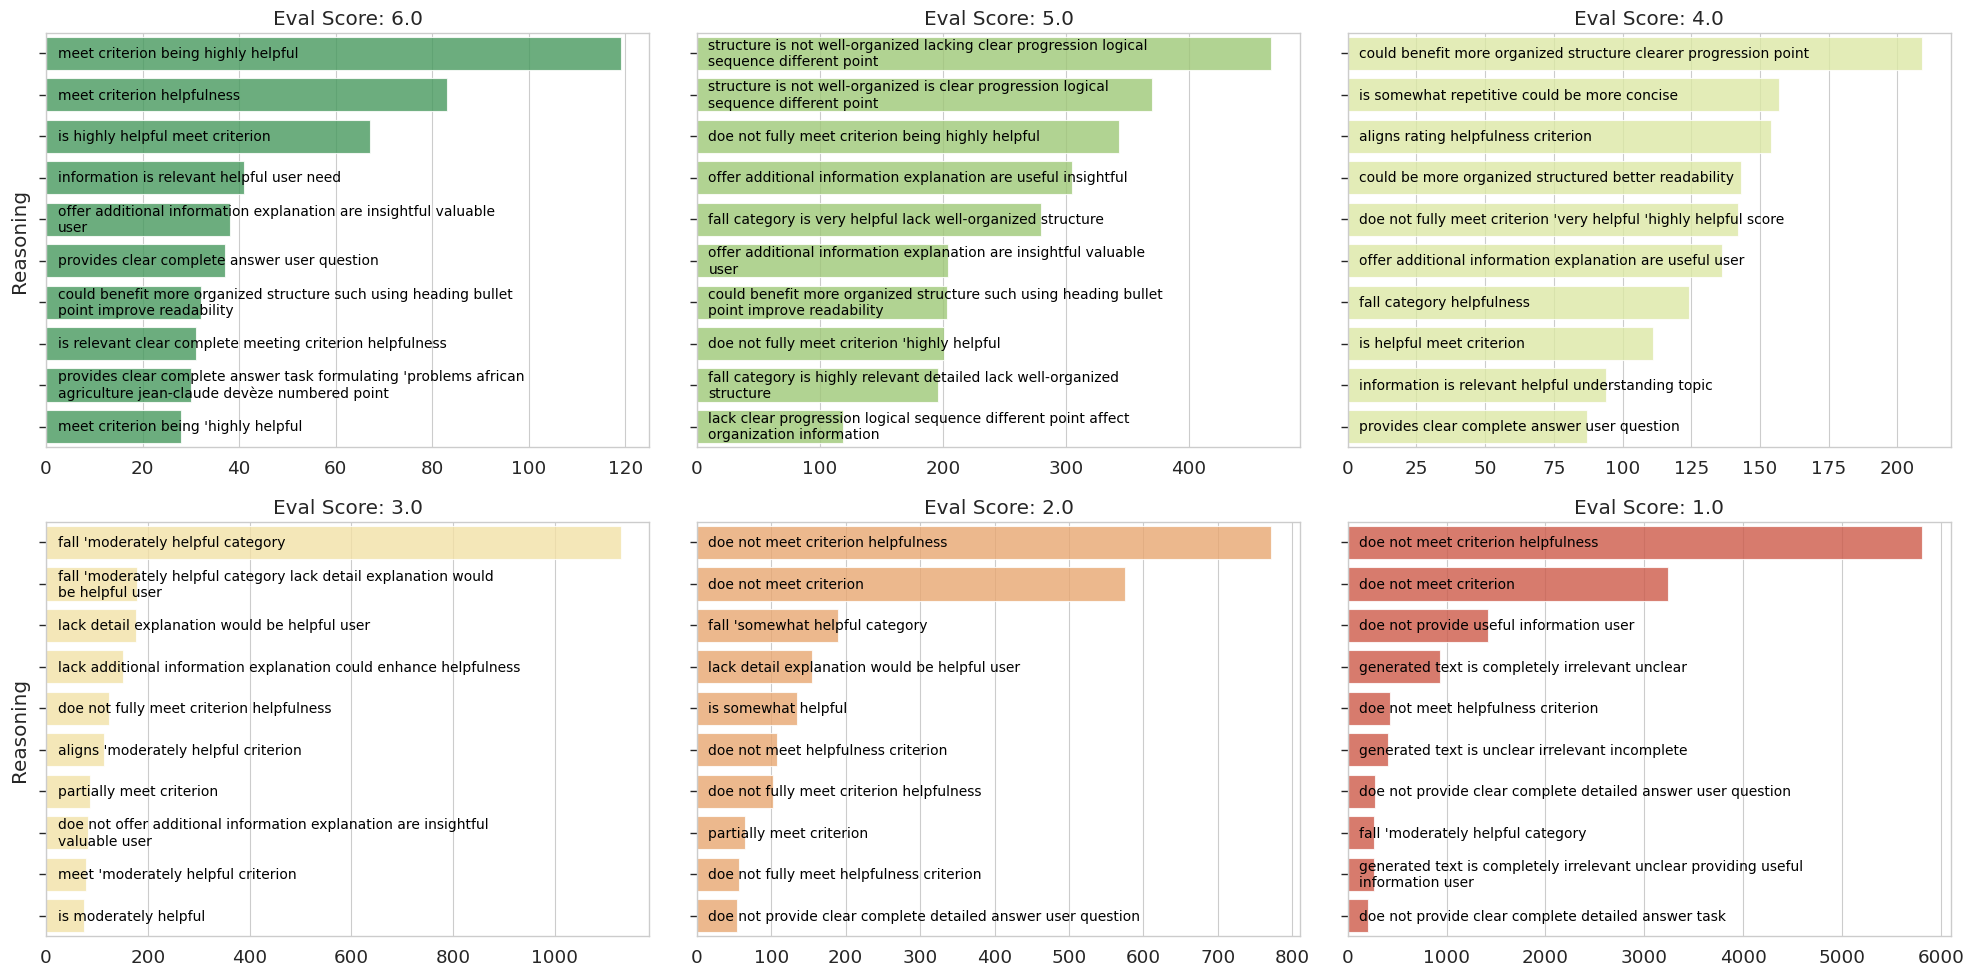

In [160]:
ruef = analyse_results_by_lang(df, 'ru')


Total results in is: 24276
Filtered results in is: 23376


  1%|          | 120/23376 [00:00<01:02, 372.63it/s]

100%|██████████| 23376/23376 [00:56<00:00, 411.58it/s]


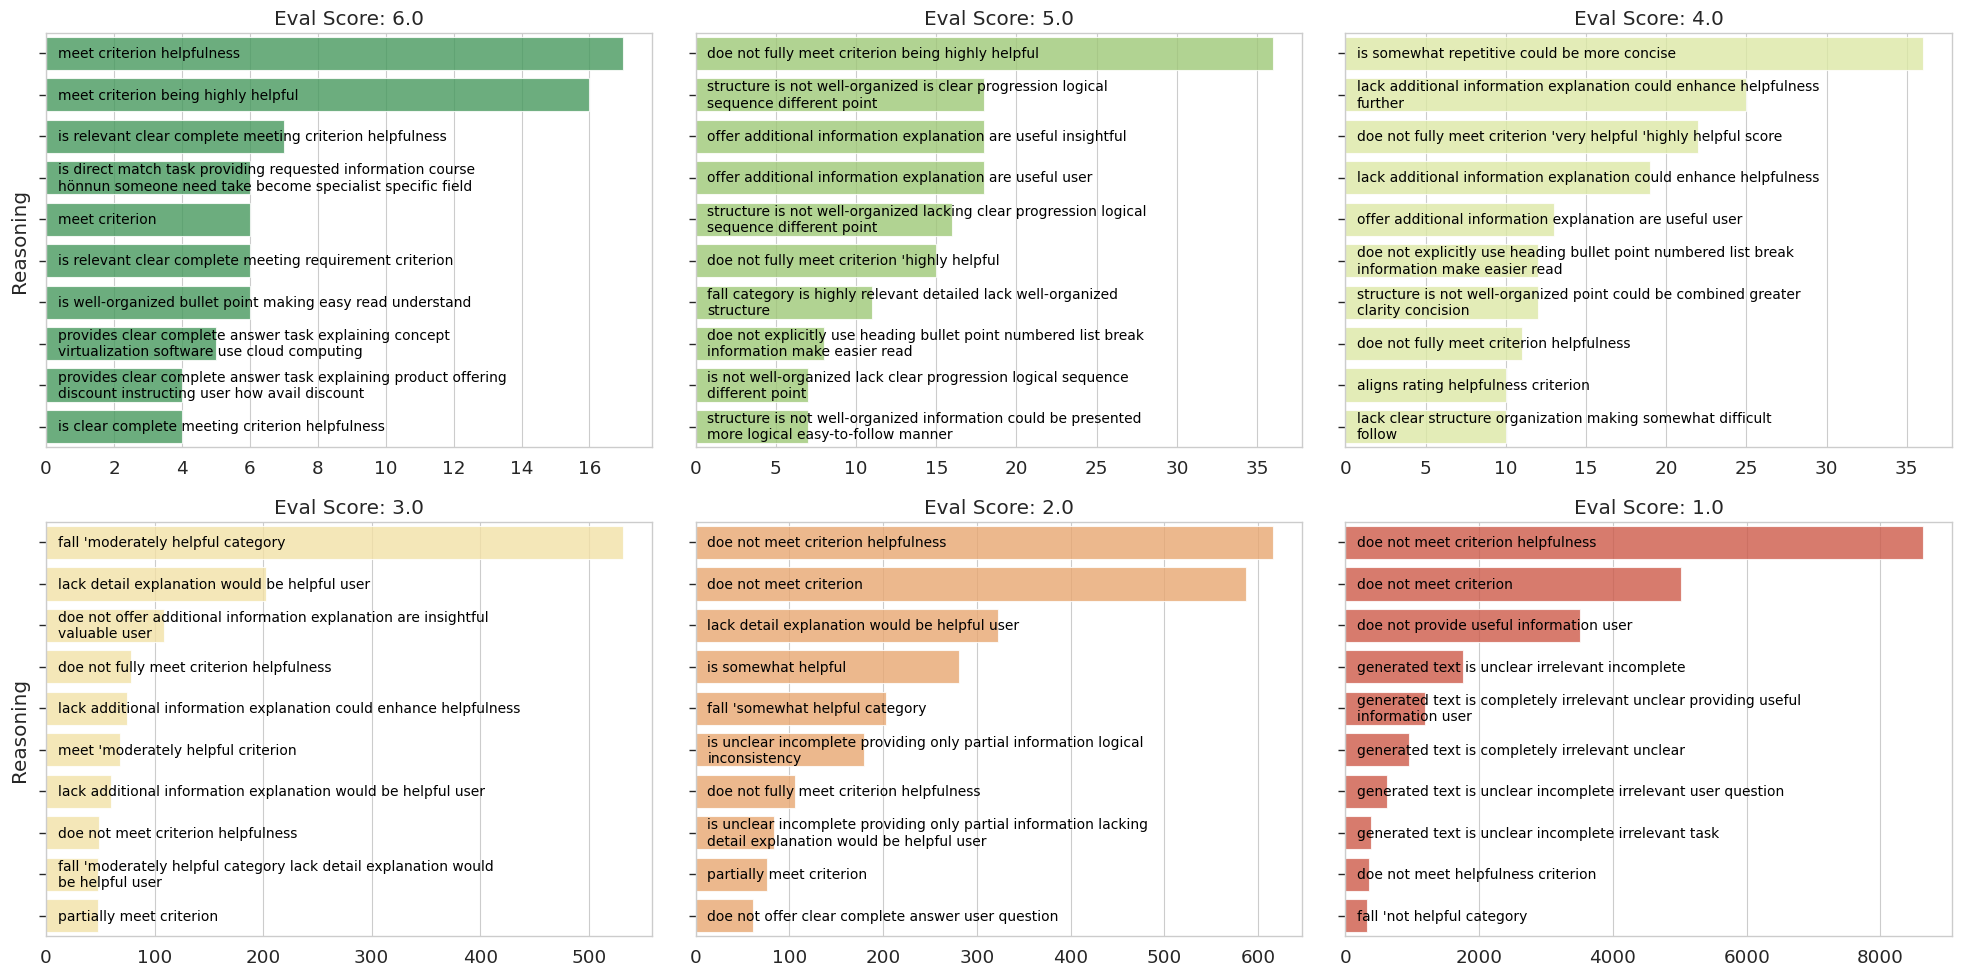

In [161]:

isef = analyse_results_by_lang(df, 'is')


Summarizing reasoning for score 5.0
detailed       2233
using          2279
such           2319
additional     2345
offers         2373
bullet         2446
question       2492
more           2636
user           3251
could          3369
answer         3672
complete       4619
However        4696
points         4732
provides       4996
is             5352
submission     5475
information    5507
response       6227
clear          6604
Name: descriptive_words, dtype: int64


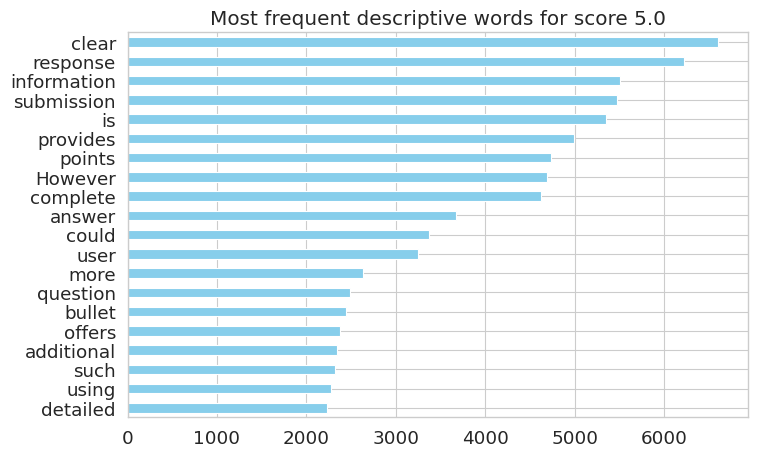

Summarizing reasoning for score 6.0
easier         1631
read           1723
task           1778
However        1800
could          1821
detailed       1886
helpful        1898
points         1950
using          2225
question       2350
relevant       2775
user           3177
answer         3489
response       3935
information    4431
complete       4680
provides       4688
clear          4972
is             5081
submission     5290
Name: descriptive_words, dtype: int64


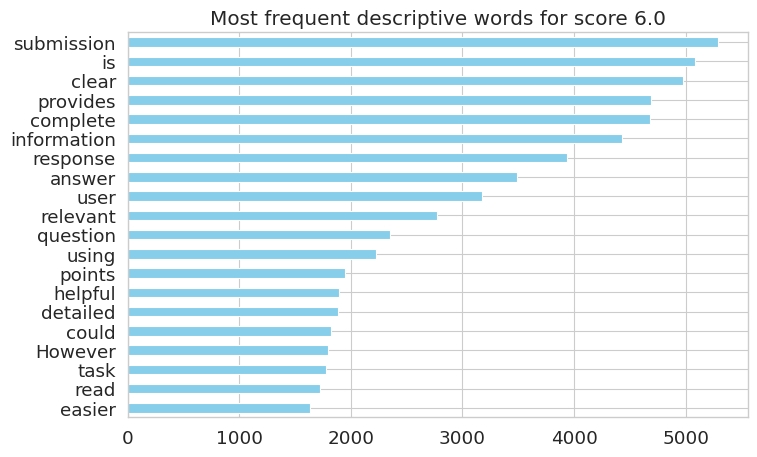

Summarizing reasoning for score 3.0
relevant       2183
'Moderately    2186
question       2285
explanation    2291
Therefore      2451
response       2454
additional     2617
could          2772
answer         2861
be             2974
information    3176
However        3289
complete       3384
lacks          3483
provides       3596
is             3693
clear          3780
user           4282
submission     5042
helpful        5175
Name: descriptive_words, dtype: int64


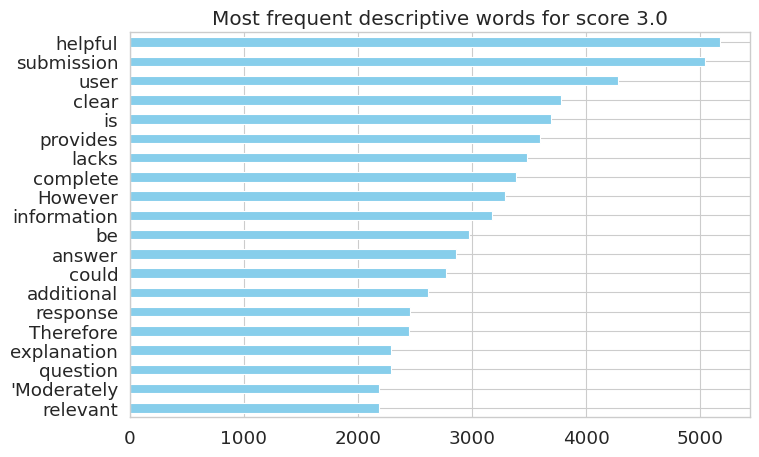

Summarizing reasoning for score 4.0
detailed       3094
clarity        3298
helpful        3458
additional     3572
relevant       4423
question       4478
more           5005
points         5096
user           5225
answer         6206
information    6490
be             6898
However        7048
complete       7551
provides       7912
clear          8580
response       8740
is             8766
could          8916
submission     9994
Name: descriptive_words, dtype: int64


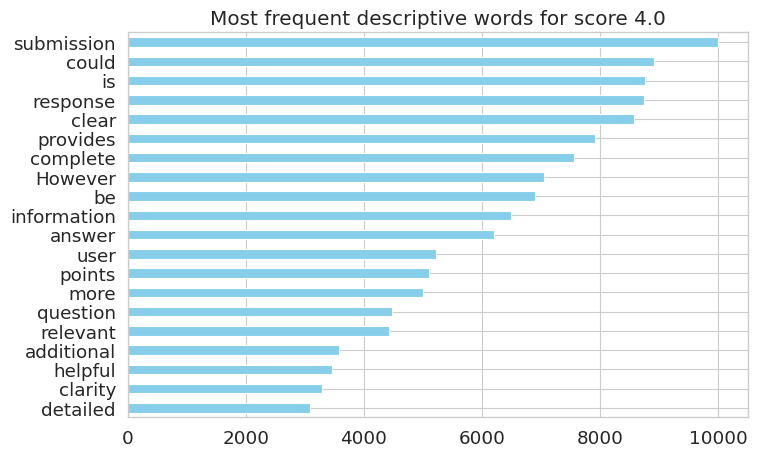

Summarizing reasoning for score 2.0
Therefore       603
relevant        624
criterion       645
However         658
complete        669
answer          698
response        718
be              773
clear           804
provides        805
task            832
somewhat        859
lacks           956
information    1016
user           1132
helpful        1177
is             1701
submission     1761
does           1873
not            2316
Name: descriptive_words, dtype: int64


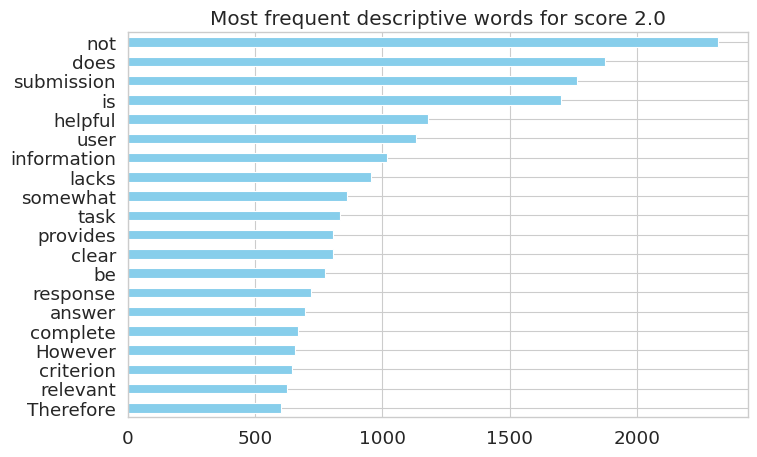

Summarizing reasoning for score 1.0
relevant       1045
useful         1069
Therefore      1088
question       1151
response       1243
helpful        1365
answer         1367
helpfulness    1409
complete       1418
provide        1482
clear          1594
meet           1706
criterion      2039
information    2093
task           2097
user           2236
is             2665
submission     3308
does           4863
not            6006
Name: descriptive_words, dtype: int64


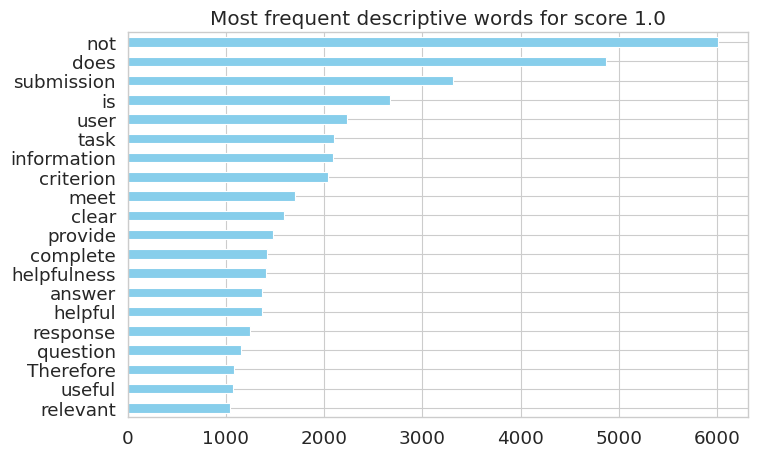

In [37]:
# # summarize reasoning words according to scores assigned

# def summarize_reasoning(df):

#     for score in df['eval_score'].unique():
#         print(f'Summarizing reasoning for score {score}')
#         terms = df[df['eval_score'] == score]['descriptive_words'].explode().value_counts().head(20)
#         # invert terms
#         terms = terms.sort_values(ascending=True)
#         print(terms)
#         # plot terms
#         terms.plot(kind='barh', title=f'Most frequent descriptive words for score {score}', figsize=(8, 5), color='skyblue')
#         plt.show()

# summarize_reasoning(endf)

